<img src='logo2.png'><br>
* ref : https://www.kaggle.com/vikrishnan/boston-house-prices?select=housing.csv

<img src="logo.png">

In [1]:
### 506rows * 14cols DataFrame 생성

In [2]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')


# from sklearn.linear_model import LogisticRegression ###---(분류 주의주의)
# -------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBClassifier
from xgboost import XGBRegressor
# from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  #잔차(실값-예측값) 제곱 합의 평균
from sklearn.metrics import mean_squared_log_error
from scipy.stats import skew, kurtosis  #왜도(skew):좌우치우침    첨도(kurt):중앙값의뾰족함정도

from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV    # =StratifiedKFold 회귀에선 사용불가

sns.set()

# Data load

In [3]:
dataset = load_boston()

In [4]:
dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [5]:
df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
df.to_csv("toy_boston_houseprice.csv", index=False)

#  EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


<pre>
crim	자치시(town)별 1인당 범죄율
zn	25,000 평방 피트를 초과하는 거주지역의 비율
indus	비소매상업지역이 차지하고 있는 토지의 비율
chas	찰스강의 경계에 위치한 경우는 1, 아니면 0
nox	10ppm 당 농축 일산화질소
rm	주택 1가구당 평균 방의 수
age	1940년 이전에 건축한 소유주택 비율
dis	보스톤 직업센터까지의 접근성 지수
rad	방사형 도로까지의 접근성 지수
tax	10,000 달러당 재산세율
ptratio	자치시(town)별 학생/교사 비율
b	자치시(town)별 흑인의 비율
lstat	모집단의 하위 계층의 비율
</pre>

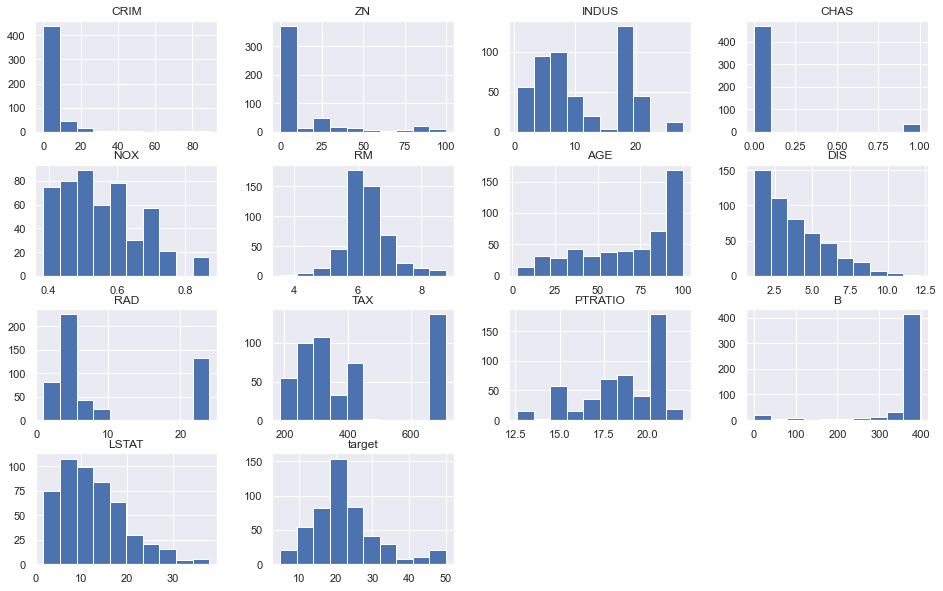

In [9]:
df.hist(figsize=(16,10))
plt.show()

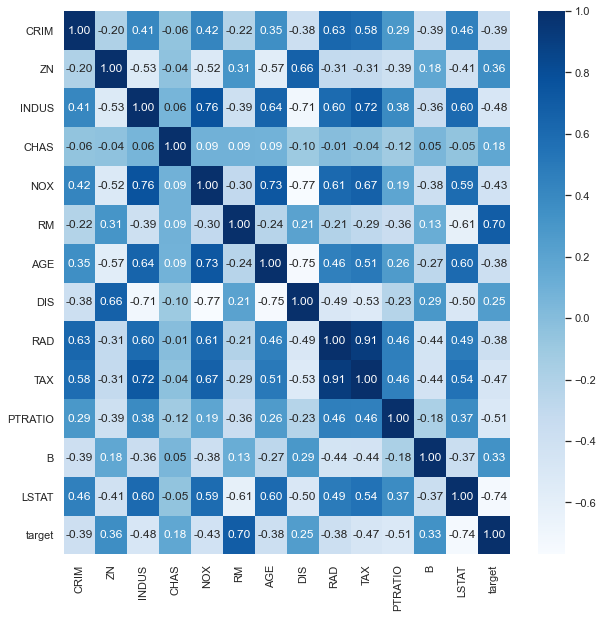

In [10]:
# 상관분석
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), fmt='.2f', annot=True, cmap='Blues')
plt.show()

In [11]:
df['RM'].describe()

count    506.000000
mean       6.284634
std        0.702617
min        3.561000
25%        5.885500
50%        6.208500
75%        6.623500
max        8.780000
Name: RM, dtype: float64

# 학습

## 데이터 분리

In [12]:
y = df['target']
X = df.drop(['target'], axis=1)

In [13]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=1414)

# 모델
* 랏쏘 : L1규제 -->  x|w|  중요하지 않은 피쳐의 회귀계수를 0으로 만들수 있다.
* 릿지 : L2규제 -->  xw^2  중요하지 않은 피쳐의 회귀계수를 0에 가깝게 만든다.(피쳐가 없어지진 않는다)
* ElasicNet , XGBoostRegressor , LightGBMRegressor, *TreeRegressor
* LogisticRegressor는 분류모델이다 ******

* ref : https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

## 평가 매트릭스 
* 잔차제곱합의평균 ( MSE )  -- SSR -- RMSL RMSLE  MAE LogLoss
*    E    S   M

<pre>
‘neg_mean_absolute_error’      metrics.mean_absolute_error
‘neg_     mean_squared_error’  metrics.mean_squared_error(squared=False)
‘neg_root_mean_squared_error’  metrics.mean_squared_error(squared=True)
‘neg_mean_squared_log_error’   metrics.mean_squared_log_error
---
‘neg_log_loss’                 metrics.log_loss (분류)
</pre>

## 1차 점수확인 : 무조건 점수부터 보자(결측x, object X)

In [14]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:
    model.fit(X_train,  y_train,)
    pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print(f"{model.__class__.__name__}\t MSE:{mse:.4f} RMSE:{rmse:.4f}")
    

LinearRegression	 MSE:34.2563 RMSE:5.8529
Ridge	 MSE:34.6178 RMSE:5.8837
Lasso	 MSE:39.0914 RMSE:6.2523
ElasticNet	 MSE:38.4532 RMSE:6.2011
DecisionTreeRegressor	 MSE:27.9262 RMSE:5.2845
XGBRegressor	 MSE:15.6989 RMSE:3.9622
LGBMRegressor	 MSE:17.3407 RMSE:4.1642


## Outlier 삭제
* CRIM	5.207652	36.752786
* CHAS	3.395799	9.531453

In [15]:
X_train.shape

(404, 13)

In [16]:
X_train[['CRIM','B']].describe()

,CRIM,B
count,404.000000,404.000000
mean,3.623255,356.627970
std,9.057974,90.774356
min,0.006320,0.320000
25%,0.071188,375.085000
50%,0.262660,391.475000
75%,3.489463,396.285000
max,88.976200,396.900000


count    404.000000
mean       3.623255
std        9.057974
min        0.006320
25%        0.071188
50%        0.262660
75%        3.489463
max       88.976200
Name: CRIM, dtype: float64


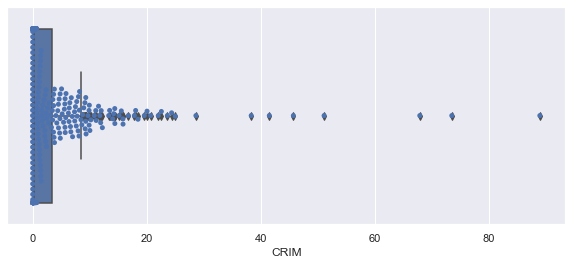

In [17]:
print(X_train['CRIM'].describe())
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=X_train['CRIM'])
sns.swarmplot(x=X_train['CRIM'])
plt.show()

count    404.000000
mean     356.627970
std       90.774356
min        0.320000
25%      375.085000
50%      391.475000
75%      396.285000
max      396.900000
Name: B, dtype: float64


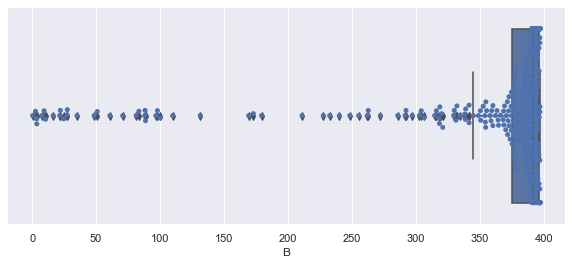

In [18]:
print(X_train['B'].describe())
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=X_train['B'])
sns.swarmplot(x=X_train['B'])
plt.show()

In [19]:
crim_idx = X_train[X_train['CRIM']>60].index

In [20]:
X_train.drop(index=crim_idx, axis=0, inplace=True)
y_train.drop(index=crim_idx, axis=0, inplace=True)

In [21]:
# df.loc[380]

In [22]:
b_idx = X_train[X_train['B']<150].index

In [23]:
X_train.drop(index=b_idx, axis=0, inplace=True)
y_train.drop(index=b_idx, axis=0, inplace=True)

In [24]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [25]:
X_train.shape, y_train.shape

((374, 13), (374,))

In [26]:
##---------------test에 있는것도 지워보자 --------- 정규분포화되서 학습이 더 잘되는지 확인해보려고
##----------------만약 공모전이라면 절대 테스트는 레코드수(500)를 줄여선 안된다. 피쳐는 지워되 된다.
b_idx = X_test[X_test['B']<150].index
crim_idx = X_test[X_test['CRIM']>60].index

print(b_idx, crim_idx)

X_test.drop(index=b_idx, axis=0, inplace=True)
y_test.drop(index=b_idx, axis=0, inplace=True)

X_test.drop(index=crim_idx, axis=0, inplace=True)
y_test.drop(index=crim_idx, axis=0, inplace=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Int64Index([434, 427, 438, 454, 423, 417, 445, 412], dtype='int64') Int64Index([], dtype='int64')



# <font color='red'>Feature Engineering
* 인싸이트 발견      

In [27]:
model = XGBRegressor(n_estimators=300, random_state=1414, learning_rate=0.1)

### 왜도 첨도 확인

In [28]:
skew_arr  = skew(df)
kurt_arr  = kurtosis(df)
print(skew_arr)
print(kurt_arr)
print(df.columns)

[ 5.20765239  2.21906306  0.29414628  3.39579929  0.72714416  0.40241467
 -0.59718559  1.00877876  1.00183349  0.66796827 -0.79994453 -2.88179835
  0.90377074  1.10481082]
[36.75278626  3.97994877 -1.23321847  9.53145284 -0.07586422  1.86102697
 -0.97001393  0.47129857 -0.8705205  -1.14298488 -0.29411638  7.14376929
  0.47654476  1.46862877]
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')


In [29]:
dict = {"skew":skew_arr, "kurt":kurt_arr}
dict_df = pd.DataFrame(dict, index=df.columns)
# dict_df = dict_df.set_index(df.columns)
dict_df.head()

,skew,kurt
CRIM,5.207652,36.752786
ZN,2.219063,3.979949
INDUS,0.294146,-1.233218
CHAS,3.395799,9.531453
NOX,0.727144,-0.075864


In [30]:
df_skew = pd.DataFrame([skew_arr, kurt_arr], columns=df.columns, index=['skew','kurt']).T
df_skew.head(20)

,skew,kurt
CRIM,5.207652,36.752786
ZN,2.219063,3.979949
INDUS,0.294146,-1.233218
CHAS,3.395799,9.531453
NOX,0.727144,-0.075864
RM,0.402415,1.861027
AGE,-0.597186,-0.970014
DIS,1.008779,0.471299
RAD,1.001833,-0.870521
TAX,0.667968,-1.142985


<AxesSubplot:>

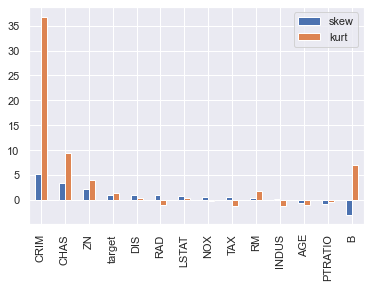

In [31]:
df_skew.sort_values('skew', ascending=False).plot(kind='bar')

<img src='logo3.png' width='900'>

## 스케일링 : 정규화

In [32]:
# MinMax Standard Rosubstic 
# skew() : 왜도 확인
# Log변환 : x(-1)없을 경우에만 사용

* y 스케일링
* y_train --> y_train_scaler
* y_test --> y_test_scaler

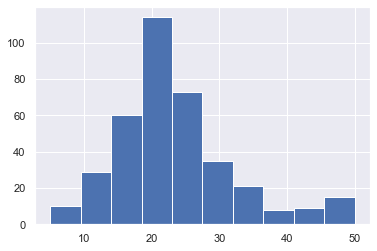

In [33]:
y_train.hist()
plt.show()

In [34]:
y_train[:5]

0    24.5
1    50.0
2    19.3
3    19.3
4    12.7
Name: target, dtype: float64

## StandardScaler()

* y (Series 8:2 ) 만 스케일링 한 경우
* y_train --> y_train_scaler
* y_test --> y_test_sacler

In [35]:
scalers = [StandardScaler()] # , RobustScaler(), MinMaxScaler()]
for mm in scalers:
    #----- Series를 array 세로줄로 바꾸는 방법 ------------------
    mm.fit(np.array(y_train).reshape(-1,1))                          # fit       : array, matrix만 가능
    #----------------------------------------------------------
    y_train_matrix = mm.transform(np.array(y_train).reshape(-1,1))   # transform : array, matrix만 가능
    y_test_matrix  = mm.transform(np.array(y_test).reshape(-1,1))    
    
    #----- matrix 2차를 array 1차로 바꾸는 방법 ------------------
    y_train_scaler = pd.Series(y_train_matrix.reshape(-1))
    #----------------------------------------------------------
    y_test_scaler  = pd.Series(y_test_matrix.reshape(-1))

print(y_train_scaler.shape)
print(y_test_scaler.shape)

(374,)
(94,)


* X (DataFrame 8:2 ) 만 스케일링 한 경우
* X_train  --> X_train_scaler
* X_test  --> X_test_sacler 

In [36]:
# X_train_scaler.hist()
# plt.show()

In [37]:
scalers = [StandardScaler()] # , RobustScaler(), MinMaxScaler()]
for mm in scalers:
    mm.fit(X_train)                            # fit       : array, matrix만 가능
    X_train_matrix = mm.transform(X_train)     # transform : array, matrix만 가능
    X_test_matrix  = mm.transform(X_test)    
    
    #print( X_train.index.values)              # index객체 --> array
                                                                           # Index객체  or array
    X_train_scaler = pd.DataFrame(X_train_matrix, columns=X_train.columns, index=X_train.index)
    X_test_scaler  = pd.DataFrame(X_test_matrix , columns=X_test.columns,  index=X_test.index)    
    
print(X_train_scaler.shape)
print(X_test_scaler.shape)

(374, 13)
(94, 13)


### 2차 점수확인 : 스케일링 후 점수

* X만 스케일한 경우 

In [38]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:
    model.fit(X_train_scaler,  y_train)      # ---------train scale
    pred = model.predict(X_test_scaler)      # ---------test  scale
    mse  = mean_squared_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print(f"{model.__class__.__name__}\t MSE:{mse:.4f} RMSE:{rmse:.4f}")

LinearRegression	 MSE:33.6297 RMSE:5.7991
Ridge	 MSE:33.6707 RMSE:5.8026
Lasso	 MSE:39.9571 RMSE:6.3212
ElasticNet	 MSE:43.1569 RMSE:6.5694
DecisionTreeRegressor	 MSE:30.7801 RMSE:5.5480
XGBRegressor	 MSE:19.3639 RMSE:4.4004
LGBMRegressor	 MSE:18.6598 RMSE:4.3197


* y만 스케일한 경우

In [39]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:
    model.fit(X_train,  y_train_scaler)      
    pred = model.predict(X_test)                                   # ---------test scale     
    mse  = mean_squared_error(y_test_scaler, pred)                 # ---------test scale
    rmse = mean_squared_error(y_test_scaler, pred, squared=False)  # ---------test  scale
    print(f"{model.__class__.__name__}\t MSE:{mse:.4f} RMSE:{rmse:.4f}")

LinearRegression	 MSE:0.4243 RMSE:0.6513
Ridge	 MSE:0.4261 RMSE:0.6528
Lasso	 MSE:0.6686 RMSE:0.8177
ElasticNet	 MSE:0.6125 RMSE:0.7826
DecisionTreeRegressor	 MSE:0.4029 RMSE:0.6347
XGBRegressor	 MSE:0.1615 RMSE:0.4018
LGBMRegressor	 MSE:0.2429 RMSE:0.4928


* X, y 모두 스케일한 경우 

In [40]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:
    model.fit(X_train_scaler,  y_train_scaler)      
    pred = model.predict(X_test_scaler)                                   # ---------test scale     
    mse  = mean_squared_error(y_test_scaler, pred)                 # ---------test scale
    rmse = mean_squared_error(y_test_scaler, pred, squared=False)  # ---------test  scale
    print(f"{model.__class__.__name__}\t MSE:{mse:.4f} RMSE:{rmse:.4f}")

LinearRegression	 MSE:0.4243 RMSE:0.6513
Ridge	 MSE:0.4248 RMSE:0.6517
Lasso	 MSE:1.1119 RMSE:1.0544
ElasticNet	 MSE:0.8174 RMSE:0.9041
DecisionTreeRegressor	 MSE:0.3811 RMSE:0.6173
XGBRegressor	 MSE:0.1616 RMSE:0.4020
LGBMRegressor	 MSE:0.2354 RMSE:0.4852


## log --> 스케일링  

In [41]:
# list = [1,5,10,20,30]
# arr = np.array(list)
# log_arr = np.log(arr)
# print(log_arr)

In [42]:
X_train_log = np.log1p(X_train)
X_test_log  = np.log1p(X_test)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [43]:
scalers = [StandardScaler()] # , RobustScaler(), MinMaxScaler()]
for mm in scalers:
    #----- Series를 array 세로줄로 바꾸는 방법 ------------------
    mm.fit(np.array(y_train_log).reshape(-1,1))                          # fit       : array, matrix만 가능
    #----------------------------------------------------------
    y_train_matrix = mm.transform(np.array(y_train_log).reshape(-1,1))   # transform : array, matrix만 가능
    y_test_matrix  = mm.transform(np.array(y_test_log).reshape(-1,1))    
    
    #----- matrix 2차를 array 1차로 바꾸는 방법 ------------------
    y_train_scaler = pd.Series(y_train_matrix.reshape(-1))
    #----------------------------------------------------------
    y_test_scaler  = pd.Series(y_test_matrix.reshape(-1))

print(y_train_scaler.shape)
print(y_test_scaler.shape)

(374,)
(94,)


In [44]:
scalers = [StandardScaler()] # , RobustScaler(), MinMaxScaler()]
for mm in scalers:
    mm.fit(X_train_log)                            # fit       : array, matrix만 가능
    X_train_matrix = mm.transform(X_train_log)     # transform : array, matrix만 가능
    X_test_matrix  = mm.transform(X_test_log)    
    
    #print( X_train.index.values)              # index객체 --> array
                                                                           # Index객체  or array
    X_train_scaler = pd.DataFrame(X_train_matrix, columns=X_train.columns, index=X_train.index)
    X_test_scaler  = pd.DataFrame(X_test_matrix , columns=X_test.columns,  index=X_test.index)    
    
print(X_train_scaler.shape)
print(X_test_scaler.shape)

(374, 13)
(94, 13)


In [45]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:
    model.fit(X_train_scaler,  y_train_scaler)      
    pred = model.predict(X_test_scaler)                                   # ---------test scale     
    mse  = mean_squared_error(y_test_scaler, pred)                 # ---------test scale
    rmse = mean_squared_error(y_test_scaler, pred, squared=False)  # ---------test  scale
    print(f"{model.__class__.__name__}\t MSE:{mse:.4f} RMSE:{rmse:.4f}")
 

LinearRegression	 MSE:0.2726 RMSE:0.5221
Ridge	 MSE:0.2733 RMSE:0.5228
Lasso	 MSE:1.0044 RMSE:1.0022
ElasticNet	 MSE:0.6935 RMSE:0.8328
DecisionTreeRegressor	 MSE:0.3799 RMSE:0.6163
XGBRegressor	 MSE:0.2130 RMSE:0.4616
LGBMRegressor	 MSE:0.1895 RMSE:0.4354


In [46]:
# sns.histplot(data=penguins, x="flipper_length_mm")

### 스케일링을 먼저 하고 로그변환하면???
*  log_3.4251456789  :  플로우 발생 (컴퓨터가 계산할수 없는 수치 발생 할 수 있다)
*  Input contains NaN, infinity or a value too large for dtype('float64').

---
<pre><font color='red'>
* 아웃라이어 선별 후 스케일링 해준다 ---> 정규화에 가까워진다
* 로그변환 후 스케일링 해주면 좋다
* 모델마다 스케일 성능이 다르다 오히려 점수가 낮아지는 모델도 있다

In [70]:
# LinearRegression	 MSE:34.2563 RMSE:5.8529
# Ridge				 MSE:34.6178 RMSE:5.8837
# Lasso				 MSE:39.0914 RMSE:6.2523
# ElasticNet		 MSE:38.4532 RMSE:6.2011
# DecisionTreeRegressor	 MSE:30.2501 RMSE:5.5000
# XGBRegressor	 MSE:15.6989 RMSE:3.9622
# LGBMRegressor	 MSE:17.3407 RMSE:4.1642

# --------------- 로그  + 스케일링
# LinearRegression	 MSE:0.2588 RMSE:0.5087
# Ridge	 MSE:0.2593 RMSE:0.5093
# Lasso	 MSE:0.9582 RMSE:0.9789
# ElasticNet	 MSE:0.6654 RMSE:0.8157
# DecisionTreeRegressor	 MSE:0.2920 RMSE:0.5403
# XGBRegressor	 MSE:0.1656 RMSE:0.4070
# LGBMRegressor	 MSE:0.1671 RMSE:0.4087


# --------------- 아웃라이어 + 로그  + 스케일링
#---------------------train만 아웃라이어 삭제
# LinearRegression	 MSE:0.4389 RMSE:0.6625
# Ridge	 MSE:0.4353 RMSE:0.6598
# Lasso	 MSE:1.1357 RMSE:1.0657
# ElasticNet	 MSE:0.7853 RMSE:0.8862
# DecisionTreeRegressor	 MSE:0.3511 RMSE:0.5925
# XGBRegressor	 MSE:0.2260 RMSE:0.4754
# LGBMRegressor	 MSE:0.2040 RMSE:0.4517


#---------------------아웃라이어 없는 상태
# LinearRegression	 MSE:0.2726 RMSE:0.5221
# Ridge	 MSE:0.2733 RMSE:0.5228
# Lasso	 MSE:1.0044 RMSE:1.0022
# ElasticNet	 MSE:0.6935 RMSE:0.8328
# DecisionTreeRegressor	 MSE:0.4573 RMSE:0.6762
# XGBRegressor	 MSE:0.2130 RMSE:0.4616
# LGBMRegressor	 MSE:0.1895 RMSE:0.4354



# 점수 더 올려보자 
* 학습량을 늘려라 - KFold, cross_var_score(cv),  GridSearchCV(cv) 
*                 ,,,,, StratifiedKFold(연속형데이터는 골로루? 분배가 안된다
* 튜닝  : 단일 모델 
* 앙상블 : 모델 조합
* 스태킹 : 모델 조합이 예측한 데이터를  다시한번 학습에 사용


In [47]:
arr = np.array([1,2,3,4,5])
arr
arr_idx = [0,1]
arr[arr_idx]

df = pd.DataFrame( {"seq":[1,2,3], "score":[40,50,60]}, index=['kim', 'hong','park'])
df.head()
# df = df.reset_index(drop=True)

# df.loc[ ['hong','park'] ]
# df.iloc[ [1,2] ]

,seq,score
kim,1,40
hong,2,50
park,3,60


### 학습량을 늘려라 - KFold

In [48]:
# pd.concate
XX_scaler = np.concatenate([X_train_scaler, X_test_scaler] , axis=0 )
yy_scaler = np.concatenate([y_train_scaler, y_test_scaler] , axis=0 )
                           
kf = KFold(n_splits=5, shuffle=True, random_state=1414)
# for train_idx, test_idx in kf.split(XX_df):      #Dataframe 통째로 다 넣어준다.
#     X_train, X_test = XX_df.iloc[train_idx], XX_df.iloc[test_idx]

tot_rmse_list = []
for train_idx, test_idx in kf.split(XX_scaler):  #array [[],[]] 통째로 다 넣어준다.
    print(train_idx[:5])
    X_train, X_test = XX_scaler[train_idx], XX_scaler[test_idx]
    y_train, y_test = yy_scaler[train_idx], yy_scaler[test_idx]
    
    model = XGBRegressor()
    model.fit(X_train,  y_train,)
    pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print(f"MSE:{mse:.4f} RMSE:{rmse:.4f}")
    tot_rmse_list.append(rmse)

print(np.mean(tot_rmse_list) )
# print(np.array(tot_rmse_list).mean() )
    

[0 1 2 3 4]
MSE:0.1915 RMSE:0.4376
[1 3 4 6 7]
MSE:0.1023 RMSE:0.3198
[0 1 2 4 5]
MSE:0.1224 RMSE:0.3498
[0 1 2 3 5]
MSE:0.1247 RMSE:0.3532
[0 2 3 4 5]
MSE:0.2030 RMSE:0.4506
0.38218846705993154


### 학습량을 늘려라 - cross_var_score(cv)

In [56]:
model = XGBRegressor()
# kf = KFold(n_splits=5, shuffle=True, random_state=1414)
array_score5 = cross_val_score(model, X=XX_scaler, y=yy_scaler, 
                               scoring='neg_root_mean_squared_error',cv=kf)
print(array_score5*-1)
print((array_score5*-1).mean())

[0.43758747 0.31978807 0.34981476 0.35319133 0.45056071]
0.38218846705993154


### 학습량을 늘려라 - cross_val__(cv) - 여러점수

In [86]:
from sklearn.model_selection import cross_validate
model = XGBRegressor()


# def my_def_AAAAAA (model):
#     return 100

# from sklearn.metrics import make_scorer
# neg_AAAAA = make_scorer(my_def_AAAAAA)


socre_dict = {"MSE":'neg_mean_squared_error' ,"RMSE":'neg_root_mean_squared_error'}  #, "MY":neg_AAAAA}
dict_score5 = cross_validate(model, X=XX_scaler, y=yy_scaler
                               , scoring=socre_dict
                               ,cv=kf)
print(dict_score5.keys())
print(dict_score5['test_MSE'])  #[-0.1914828  -0.10226441 -0.12237036 -0.12474412 -0.20300495]
print(dict_score5['test_RMSE'])  #[-0.1914828  -0.10226441 -0.12237036 -0.12474412 -0.20300495]
print((dict_score5['test_RMSE']*-1).mean())

dict_keys(['fit_time', 'score_time', 'test_MSE', 'test_RMSE'])
[-0.1914828  -0.10226441 -0.12237036 -0.12474412 -0.20300495]
[-0.43758747 -0.31978807 -0.34981476 -0.35319133 -0.45056071]
0.38218846705993154


# <font color=red>TODO</font>

In [76]:
# model = XGBRegressor()
# # kf = KFold(n_splits=5, shuffle=True, random_state=1414)

# # pd.concate
# # XX_scaler = np.concatenate([X_train_scaler, X_test_scaler] , axis=0 )
# # yy_scaler = np.concatenate([y_train_scaler, y_test_scaler] , axis=0 )

# from sklearn.metrics import make_scorer
# neg_MAKE_SCORES_DEF = make_scorer(my_score_DEF)


# def my_score_DEF (model):
#     pred = model.predict(y_true, y_pred)
#     mse  = mean_squared_error(y_true, y_pred)
#     rmse = mean_squared_error(y_true, y_pred, squared=False)
#     return mse, rmse

# # scoreing == str or callable
# array_score5 = cross_val_score(model, X=XX_scaler, y=yy_scaler
#                                , scoring=neg_MAKE_SCORES_DEF
#                                ,cv=kf)
# print(array_score5*-1)
# print((array_score5*-1).mean())

### 학습량을 늘려라 - GridSearchCV(튜닝 + cv)

In [91]:
model = XGBRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=1414)

#============ 어설프게 했더니 안하니만 못하다 ~~!!!!  0.3821  --> 0.4869
hyper_param = {'n_estimators':[5, 6, 7],
              'learning_rate':[0.01, 0.1, 1,2,3,4,]
               }
# socre_dict = {"MSE":'neg_mean_squared_error' ,"RMSE":'neg_root_mean_squared_error'}  
# gcv_model = GridSearchCV(model, param_grid=hyper_param, scoring=socre_dict, refit='RMSE', cv=kf)  #, return_train_score=True)

gcv_model = GridSearchCV(model, param_grid=hyper_param, scoring='neg_root_mean_squared_error'
                         , refit=True, cv=kf)  

print(gcv_model.get_params().values())

gcv_model.fit(XX_scaler,yy_scaler)
print(-1*gcv_model.best_score_)
print(gcv_model.best_params_)


dict_values([KFold(n_splits=5, random_state=1414, shuffle=True), nan, 'reg:squarederror', None, None, None, None, None, None, None, 'gain', None, None, None, None, None, nan, None, 100, None, None, None, None, None, None, None, None, None, None, XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), None, {'n_estimators': [5, 6, 7], 'learning_rate': [0.01, 0.1, 1, 2, 3, 4]}, '2*n_jobs', True, False, 'neg_root_mean_squared_error

### list array scaler 연습

In [50]:
matrix = [[1,2,3],
          [10,20,30]
         ]  #2*3
df = pd.DataFrame(matrix)
df.shape                        #2*3

(2, 3)

In [51]:
list = [0,1,2,9,10]
scaler = StandardScaler()
# arr = scaler.fit_transform(list)                            # --> 리스트 가로줄 error
# arr = scaler.fit_transform(np.array(list))                  # --> 배열   가로줄   error
matrix = scaler.fit_transform(np.array(list).reshape(-1,1))   # --> 배열   세로줄   ok 
print(matrix.shape, matrix)                                         # --> (5, 1) [[] [] []]        2-dimensional
# df['ss_std'] = matrix
#s = pd.Series(matrix)                                        # --> 매트릭스      error  []   1-dimensional

# [[][]]  --> []      2-dimensional --> 1-dimensional
arr = matrix.reshape(-1)
print(arr.shape, arr)                                         # --> (5, 1) [[] [] []]        2-dimensional

(5, 1) [[-1.04173019]
 [-0.80497333]
 [-0.56821647]
 [ 1.08908156]
 [ 1.32583843]]
(5,) [-1.04173019 -0.80497333 -0.56821647  1.08908156  1.32583843]


In [52]:
arr = np.array([0,1,2,9,10])
print(arr.shape, arr)
s = pd.Series(arr)
print(s)

(5,) [ 0  1  2  9 10]
0     0
1     1
2     2
3     9
4    10
dtype: int32
